# Conjunctivitis classification with MobileNetV3 (PyTorch)

This notebook trains and evaluates a MobileNetV3 (lightweight) model on a binary conjunctivitis dataset organized as: `Dataset/healthy_eye/` and `Dataset/infected_eye/`.

Requirements: see `../requirements.txt`.

In [15]:
# Install (optional) - run in notebook kernel if needed
!pip install -r ../requirements.txt


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [14]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets, models
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold

In [ ]:
# Config
DATA_DIR = Path('..') / 'Dataset'
BATCH_SIZE = 32
IMG_SIZE = 224
NUM_CLASSES = 2
NUM_EPOCHS = 12
LR = 1e-3
WEIGHT_DECAY = 1e-4
SEED = 42
K_FOLDS = 5  # Number of folds for cross-validation
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('device:', DEVICE)
print('data dir exists:', DATA_DIR.exists())
print(f'Using {K_FOLDS}-Fold Cross-Validation')

device: cpu
data dir exists: True


In [4]:
# Reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

In [5]:
# Transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

In [ ]:
# Load dataset to extract labels for stratified k-fold
full_dataset = datasets.ImageFolder(root=str(DATA_DIR), transform=val_transform)
class_names = full_dataset.classes
print('classes:', class_names)
print(f'Total images: {len(full_dataset)}')

# Extract labels for stratified k-fold (maintains class distribution across folds)
labels = np.array([full_dataset.targets[i] for i in range(len(full_dataset))])

# Setup stratified k-fold
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)
fold_splits = list(skf.split(np.arange(len(full_dataset)), labels))

print(f'\nK-Fold setup: {K_FOLDS} folds')
for fold_idx, (train_idx, val_idx) in enumerate(fold_splits):
    train_counts = np.bincount(labels[train_idx])
    val_counts = np.bincount(labels[val_idx])
    print(f'  Fold {fold_idx+1}: train={len(train_idx)} ({class_names[0]}: {train_counts[0]}, {class_names[1]}: {train_counts[1]}), val={len(val_idx)} ({class_names[0]}: {val_counts[0]}, {class_names[1]}: {val_counts[1]})')

classes: ['healthy_eye', 'infected_eye']
train images: 288, val images: 72


/Users/noormustafa/Documents/GitHub/disease_detection/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:1118: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


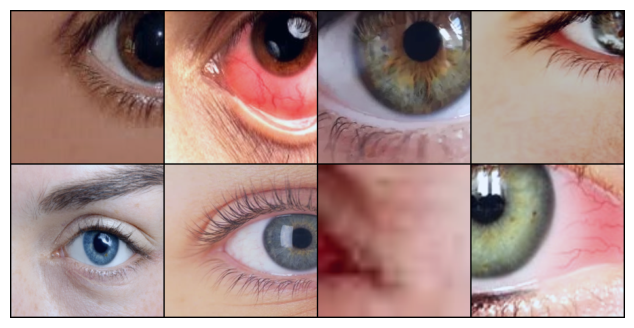

In [ ]:
from torch.utils.data import Subset

# Use first fold for visualization
first_train_idx, first_val_idx = fold_splits[0]
train_ds = Subset(datasets.ImageFolder(root=str(DATA_DIR), transform=train_transform), first_train_idx)
val_ds = Subset(datasets.ImageFolder(root=str(DATA_DIR), transform=val_transform), first_val_idx)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# quick visual check
import torchvision.utils as vutils
batch = next(iter(train_loader))
images, labels_batch = batch
grid = vutils.make_grid(images[:8], nrow=4, normalize=True)
plt.figure(figsize=(8,4))
plt.imshow(np.transpose(grid.cpu().numpy(), (1,2,0)))
plt.axis('off')
plt.title('Sample training images (Fold 1)')
plt.show()

In [ ]:
def build_model():
    """Create a fresh MobileNetV3 model"""
    model = models.mobilenet_v3_small(pretrained=True)
    in_features = None
    for m in model.classifier:
        if isinstance(m, nn.Linear):
            in_features = m.in_features
            break
    if in_features is None:
        try:
            in_features = model.classifier[0].in_features
        except Exception:
            raise RuntimeError('Could not determine classifier in_features for MobileNetV3')
    
    model.classifier = nn.Sequential(
        nn.Linear(in_features, 256),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(256, NUM_CLASSES)
    )
    return model.to(DEVICE)

# Show model architecture
sample_model = build_model()
print(sample_model)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

/Users/noormustafa/Documents/GitHub/disease_detection/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/noormustafa/Documents/GitHub/disease_detection/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# K-Fold Cross-Validation Training Loop
save_path = Path('..') / 'models'
save_path.mkdir(exist_ok=True)

fold_results = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'best_val_acc_per_fold': [],
    'all_fold_preds': [],
    'all_fold_targets': []
}

print("="*70)
print(f"Starting {K_FOLDS}-Fold Cross-Validation")
print("="*70)

for fold_idx, (train_idx, val_idx) in enumerate(fold_splits):
    print(f"\n{'='*70}")
    print(f"FOLD {fold_idx + 1}/{K_FOLDS}")
    print(f"{'='*70}")
    
    # Create data loaders for this fold
    train_ds_fold = Subset(datasets.ImageFolder(root=str(DATA_DIR), transform=train_transform), train_idx)
    val_ds_fold = Subset(datasets.ImageFolder(root=str(DATA_DIR), transform=val_transform), val_idx)
    
    train_loader_fold = DataLoader(train_ds_fold, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
    val_loader_fold = DataLoader(val_ds_fold, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
    
    # Build fresh model for this fold
    model = build_model()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    
    best_val_acc = 0.0
    best_model_file = save_path / f'mobilenetv3_fold_{fold_idx+1}.pth'
    
    fold_train_loss = []
    fold_train_acc = []
    fold_val_loss = []
    fold_val_acc = []
    
    # Training epochs for this fold
    for epoch in range(1, NUM_EPOCHS + 1):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        pbar = tqdm(train_loader_fold, desc=f'Epoch {epoch}/{NUM_EPOCHS}', leave=False)
        
        for inputs, targets in pbar:
            inputs = inputs.to(DEVICE)
            targets = targets.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            preds = outputs.argmax(dim=1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += (preds == targets).sum().item()
            pbar.set_postfix(loss=loss.item())
        
        epoch_loss = running_loss / len(train_loader_fold.dataset)
        epoch_acc = running_corrects / len(train_loader_fold.dataset)
        fold_train_loss.append(epoch_loss)
        fold_train_acc.append(epoch_acc)
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for inputs, targets in val_loader_fold:
                inputs = inputs.to(DEVICE)
                targets = targets.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                preds = outputs.argmax(dim=1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += (preds == targets).sum().item()
                all_preds.extend(preds.cpu().numpy().tolist())
                all_targets.extend(targets.cpu().numpy().tolist())
        
        val_loss = val_loss / len(val_loader_fold.dataset)
        val_acc = val_corrects / len(val_loader_fold.dataset)
        fold_val_loss.append(val_loss)
        fold_val_acc.append(val_acc)
        
        print(f'  Epoch {epoch}: train_loss={epoch_loss:.4f}, train_acc={epoch_acc:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}')
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({'model_state_dict': model.state_dict(), 'class_names': class_names}, best_model_file)
            print(f'  ✓ Saved best model (val_acc={val_acc:.4f})')
        
        scheduler.step()
    
    # Store fold results
    fold_results['train_loss'].append(fold_train_loss)
    fold_results['train_acc'].append(fold_train_acc)
    fold_results['val_loss'].append(fold_val_loss)
    fold_results['val_acc'].append(fold_val_acc)
    fold_results['best_val_acc_per_fold'].append(best_val_acc)
    fold_results['all_fold_preds'].append(all_preds)
    fold_results['all_fold_targets'].append(all_targets)
    
    print(f"\nFold {fold_idx + 1} - Best validation accuracy: {best_val_acc:.4f}")

print("\n" + "="*70)
print("Cross-Validation Summary")
print("="*70)
mean_best_acc = np.mean(fold_results['best_val_acc_per_fold'])
std_best_acc = np.std(fold_results['best_val_acc_per_fold'])
print(f"Mean validation accuracy across folds: {mean_best_acc:.4f} (+/- {std_best_acc:.4f})")
for fold_idx, acc in enumerate(fold_results['best_val_acc_per_fold']):
    print(f"  Fold {fold_idx + 1}: {acc:.4f}")
print("="*70)

Epoch 1/12 - train: 100%|██████████| 9/9 [00:42<00:00,  4.70s/it, loss=0.406]


Epoch 1: train_loss=0.5556 train_acc=0.6910 val_loss=0.3768 val_acc=0.7917
Saved best model to ../models/mobilenetv3_best.pth


Epoch 2/12 - train: 100%|██████████| 9/9 [00:42<00:00,  4.70s/it, loss=0.116] 


Epoch 2: train_loss=0.2099 train_acc=0.9375 val_loss=0.2520 val_acc=0.9167
Saved best model to ../models/mobilenetv3_best.pth


Epoch 3/12 - train: 100%|██████████| 9/9 [00:42<00:00,  4.70s/it, loss=0.0107]


Epoch 3: train_loss=0.1013 train_acc=0.9583 val_loss=0.1658 val_acc=0.9583
Saved best model to ../models/mobilenetv3_best.pth


Epoch 4/12 - train: 100%|██████████| 9/9 [00:42<00:00,  4.69s/it, loss=0.0524]


Epoch 4: train_loss=0.1428 train_acc=0.9479 val_loss=0.0328 val_acc=0.9861
Saved best model to ../models/mobilenetv3_best.pth


Epoch 5/12 - train: 100%|██████████| 9/9 [00:42<00:00,  4.70s/it, loss=0.208] 


Epoch 5: train_loss=0.1428 train_acc=0.9549 val_loss=0.0131 val_acc=1.0000
Saved best model to ../models/mobilenetv3_best.pth


Epoch 6/12 - train: 100%|██████████| 9/9 [00:42<00:00,  4.76s/it, loss=0.135] 


Epoch 6: train_loss=0.1318 train_acc=0.9479 val_loss=0.0166 val_acc=1.0000


Epoch 7/12 - train: 100%|██████████| 9/9 [00:42<00:00,  4.77s/it, loss=0.0446]


Epoch 7: train_loss=0.1759 train_acc=0.9444 val_loss=0.0248 val_acc=0.9861


Epoch 8/12 - train: 100%|██████████| 9/9 [00:42<00:00,  4.72s/it, loss=0.0429]


Epoch 8: train_loss=0.0946 train_acc=0.9792 val_loss=0.0335 val_acc=0.9861


Epoch 9/12 - train: 100%|██████████| 9/9 [00:42<00:00,  4.70s/it, loss=0.0318]


Epoch 9: train_loss=0.0792 train_acc=0.9722 val_loss=0.0374 val_acc=0.9861


Epoch 10/12 - train: 100%|██████████| 9/9 [00:42<00:00,  4.72s/it, loss=0.0448]


Epoch 10: train_loss=0.1061 train_acc=0.9618 val_loss=0.0384 val_acc=0.9861


Epoch 11/12 - train: 100%|██████████| 9/9 [00:43<00:00,  4.81s/it, loss=0.018] 


Epoch 11: train_loss=0.0678 train_acc=0.9861 val_loss=0.0353 val_acc=0.9861


Epoch 12/12 - train: 100%|██████████| 9/9 [00:42<00:00,  4.69s/it, loss=0.0219]


Epoch 12: train_loss=0.0534 train_acc=0.9792 val_loss=0.0334 val_acc=0.9861


Classification Report:
              precision    recall  f1-score   support

 healthy_eye       1.00      1.00      1.00        34
infected_eye       1.00      1.00      1.00        38

    accuracy                           1.00        72
   macro avg       1.00      1.00      1.00        72
weighted avg       1.00      1.00      1.00        72



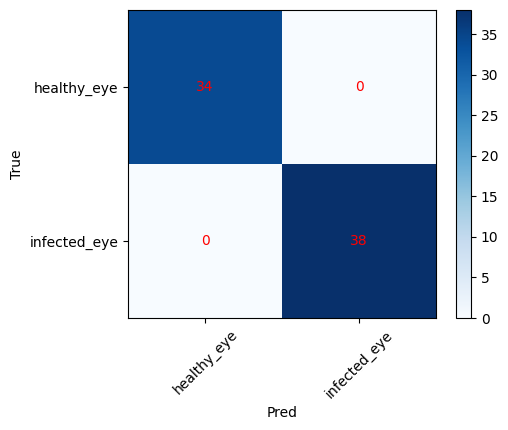

In [ ]:
# Aggregate metrics from all folds for comprehensive evaluation
print("="*70)
print("CROSS-VALIDATION EVALUATION - Aggregated Results")
print("="*70)

all_preds_cv = []
all_targets_cv = []

for fold_idx in range(K_FOLDS):
    all_preds_cv.extend(fold_results['all_fold_preds'][fold_idx])
    all_targets_cv.extend(fold_results['all_fold_targets'][fold_idx])

print(f"\nTotal predictions across all folds: {len(all_preds_cv)}")
print("\nAggregated Classification Report (all folds combined):")
print(classification_report(all_targets_cv, all_preds_cv, target_names=class_names))

# Confusion matrix for aggregated results
cm = confusion_matrix(all_targets_cv, all_preds_cv)
plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap='Blues')
plt.xticks([0, 1], class_names, fontsize=12)
plt.yticks([0, 1], class_names, fontsize=12)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='red', fontsize=14, fontweight='bold')
plt.colorbar(label='Count')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.title('Confusion Matrix - K-Fold Cross-Validation (Aggregated)', fontsize=14)
plt.tight_layout()
plt.show()

# Plot per-fold accuracies
plt.figure(figsize=(10, 5))
folds = list(range(1, K_FOLDS + 1))
best_accs = fold_results['best_val_acc_per_fold']
plt.bar(folds, best_accs, color='steelblue', alpha=0.7, edgecolor='black')
plt.axhline(y=np.mean(best_accs), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(best_accs):.4f}')
plt.xlabel('Fold', fontsize=12)
plt.ylabel('Best Validation Accuracy', fontsize=12)
plt.title('Per-Fold Best Validation Accuracy', fontsize=14)
plt.xticks(folds)
plt.ylim([0.8, 1.05])
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*70)

In [ ]:
# Load the best model from the best performing fold
best_fold_idx = np.argmax(fold_results['best_val_acc_per_fold'])
best_fold_acc = fold_results['best_val_acc_per_fold'][best_fold_idx]
best_model_file = save_path / f'mobilenetv3_fold_{best_fold_idx+1}.pth'

print(f"Loading best model from Fold {best_fold_idx + 1} (accuracy: {best_fold_acc:.4f})")
checkpoint = torch.load(best_model_file, map_location=DEVICE)
model = build_model()
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(DEVICE)
model.eval()

# Also save a copy as the main model file for later use
main_model_file = save_path / 'mobilenetv3_best.pth'
torch.save(checkpoint, main_model_file)
print(f"Saved best model to {main_model_file}")

# Inference helper
from PIL import Image
def predict_image(img_path, model, transform, class_names):
    img = Image.open(img_path).convert('RGB')
    x = transform(img).unsqueeze(0).to(DEVICE)
    model.eval()
    with torch.no_grad():
        out = model(x)
        p = torch.softmax(out, dim=1)
        conf, pred = torch.max(p, dim=1)
    return class_names[pred.item()], conf.item()

print("Model ready for inference")

In [12]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import random

def test_on_dataset_images():
    """
    Test predictions on random images from the dataset.
    - Selects 5 random images from the dataset
    - Displays predictions with confidence scores
    """
    dataset_dir = Path('..') / 'Dataset'
    
    if not dataset_dir.exists():
        print("❌ Error: Dataset directory not found at", dataset_dir)
        return
    
    # Get all image files from both classes
    all_images = []
    for class_dir in dataset_dir.iterdir():
        if class_dir.is_dir():
            for img_file in class_dir.glob('*.*'):
                if img_file.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp']:
                    all_images.append(img_file)
    
    if not all_images:
        print("❌ Error: No images found in dataset")
        return
    
    print(f"📷 Found {len(all_images)} total images in dataset")
    print("Testing on 5 random images...\n")
    
    # Select 5 random images
    test_images = random.sample(all_images, min(5, len(all_images)))
    predictions = []
    
    for idx, img_path in enumerate(test_images):
        try:
            # Load and predict
            img = Image.open(img_path).convert('RGB')
            x = val_transform(img).unsqueeze(0).to(DEVICE)
            
            model.eval()
            with torch.no_grad():
                out = model(x)
                p = torch.softmax(out, dim=1)
                conf, pred = torch.max(p, dim=1)
            
            pred_class = class_names[pred.item()]
            pred_conf = conf.item()
            probs = p[0].cpu().numpy()
            
            predictions.append({
                'frame': idx + 1,
                'path': str(img_path.name),
                'true_class': img_path.parent.name,
                'pred_class': pred_class,
                'confidence': pred_conf,
                'probs': probs,
                'image': np.array(img.resize((300, 300)))
            })
            
            match = "✓" if pred_class == img_path.parent.name else "✗"
            print(f"Image {idx + 1}/5: {match} Predicted {pred_class.upper()} ({pred_conf:.1%})")
            
        except Exception as e:
            print(f"❌ Error processing {img_path.name}: {str(e)}")
    
    # Display all predictions
    if predictions:
        fig, axes = plt.subplots(1, len(predictions), figsize=(16, 4))
        if len(predictions) == 1:
            axes = [axes]
        
        for idx, pred in enumerate(predictions):
            ax = axes[idx]
            ax.imshow(pred['image'])
            
            # Color: green if correct, red if wrong
            is_correct = pred['pred_class'] == pred['true_class']
            color = 'green' if is_correct else 'red'
            status = "✓" if is_correct else "✗"
            
            title = f"{status} True: {pred['true_class']}\nPred: {pred['pred_class']}\n{pred['confidence']:.1%}"
            ax.set_title(title, color=color, fontsize=10, fontweight='bold')
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Summary statistics
        print("\n" + "="*70)
        print("📊 SUMMARY OF PREDICTIONS:")
        print("="*70)
        correct = 0
        for pred in predictions:
            is_correct = pred['pred_class'] == pred['true_class']
            correct += is_correct
            status = "✓ CORRECT" if is_correct else "✗ WRONG"
            print(f"{status} | True: {pred['true_class']:15} | Pred: {pred['pred_class']:15} | Conf: {pred['confidence']:.2%}")
        
        accuracy = (correct / len(predictions)) * 100
        print(f"\n✓ Accuracy on this sample: {correct}/{len(predictions)} ({accuracy:.1f}%)")
        print("="*70)

# Run testing on dataset images - Uncomment below to start
# test_on_dataset_images()


In [13]:
from ipywidgets import FileUpload, Button, Output, VBox, Label
from IPython.display import display, Image as IPImage
import io

# Create file uploader widget
file_uploader = FileUpload(accept='image/*', multiple=False, description='Upload Image:')
predict_button = Button(description='Predict')
output_display = Output()

def on_predict_clicked(b):
    """Handle prediction when button is clicked"""
    output_display.clear_output()
    
    with output_display:
        if len(file_uploader.value) == 0:
            print("❌ Please select an image first!")
            return
        
        # Get the uploaded file
        uploaded_file = file_uploader.value[0]
        file_content = uploaded_file['content']
        
        try:
            # Load image
            img = Image.open(io.BytesIO(file_content)).convert('RGB')
            
            # Display the uploaded image
            print("📷 Uploaded Image:")
            display(img)
            
            # Apply transform and predict
            x = val_transform(img).unsqueeze(0).to(DEVICE)
            
            model.eval()
            with torch.no_grad():
                out = model(x)
                p = torch.softmax(out, dim=1)
                conf, pred = torch.max(p, dim=1)
            
            pred_class = class_names[pred.item()]
            pred_conf = conf.item()
            
            # Display prediction
            print(f"\n{'='*60}")
            print(f"🔍 PREDICTION: {pred_class.upper()}")
            print(f"✓ Confidence: {pred_conf:.4f} ({pred_conf*100:.2f}%)")
            
            # Show confidence for both classes
            probs = torch.softmax(out, dim=1)[0].cpu().numpy()
            print(f"\nDetailed Probabilities:")
            for i, class_name in enumerate(class_names):
                print(f"  {class_name}: {probs[i]:.4f} ({probs[i]*100:.2f}%)")
            print(f"{'='*60}")
            
        except Exception as e:
            print(f"❌ Error processing image: {str(e)}")

# Attach click handler
predict_button.on_click(on_predict_clicked)

# Display widgets
print("Upload an eye image and click 'Predict' to test the model:")
display(VBox([file_uploader, predict_button, output_display]))


Upload an eye image and click 'Predict' to test the model:


## Notes and next steps
- Tune learning rate, batch size, augmentations.
- Consider transfer learning freezes: initially freeze backbone features and train classifier, then unfreeze.
- For small datasets, use stronger augmentation and possibly k-fold cross-validation.
- If you need an object-detection approach (localizing signs), consider a YOLOv8 workflow instead.